In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

import time

# **Data Prepocessing**

In [2]:

df2018 = pd.read_csv('./2018Floor5.csv')
df2019 = pd.read_csv('./2019Floor5.csv')
df = pd.concat([df2018, df2019], ignore_index=True)

# Transformasi data
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
energy = df[['Date', 'z1_AC4(kW)']].copy() 
energy.rename(columns={'z1_AC4(kW)': 'y'}, inplace=True)

energy.set_index('Date', inplace=True)

energy = energy.resample('d').sum() * (1/60)

energy = energy.reset_index()

# **Pembuatan Fitur Lag**

In [3]:
#untuk model xgboost, rf, svr
energy_lag = energy.copy()
for i in range(1, 8):
    energy_lag[f'lag_{i}'] = energy_lag['y'].shift(i)
energy_lag = energy_lag.dropna().reset_index(drop=True)
X_2d = energy_lag.drop(columns=['Date','y'])
y_2d = energy_lag['y'] 

In [4]:
#untuk model lstm
energy_window = energy.copy()
energy_window = energy_window.drop(columns=['Date'])

def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps, :]) 
        y.append(data[i+timesteps, 0]) 
    return np.array(X), np.array(y)

X_3d, y_3d = create_sequences(energy_window.values, 7)

# **Data Split**

In [6]:
def split_dataset(X, y):
    train_size = int(0.6 * len(X))  #60% training
    val_size = train_size + int(0.2 * len(X))  #20% validation

    X_train, X_val, X_test = X[:train_size], X[train_size:val_size], X[val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:val_size], y[val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
#untuk model xgboost, rf, svr
X_train_2d, y_train_2d, X_val_2d, y_val_2d, X_test_2d, y_test_2d = split_dataset(X_2d, y_2d)

In [8]:
#untuk model lstm
X_train_3d, y_train_3d, X_val_3d, y_val_3d, X_test_3d, y_test_3d = split_dataset(X_3d, y_3d)

In [9]:
#untuk arima
train_size = int(len(energy) * 0.8)
train_data, test_data = energy.iloc[:train_size], energy.iloc[train_size:]

train_arima = train_data['y']
test_arima = test_data['y']

# **Normalisasi Data**

In [10]:
#untuk model xgb, rf, svr
def norm_2d(X_train, y_train, X_val, y_val, X_test, y_test):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)
    
    y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_val = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler_y

X_train_2ds, y_train_2ds, X_val_2ds, y_val_2ds, X_test_2ds, y_test_2ds, scaler_y = norm_2d(X_train_2d, y_train_2d, X_val_2d, y_val_2d, X_test_2d, y_test_2d)

In [11]:
#untuk model lstm
def norm_3d(X_train, y_train, X_val, y_val, X_test, y_test):
    scaler_X = {}
    scaler_y = MinMaxScaler()

    # Scaling fitur per channel
    for feature_idx in range(X_train.shape[2]):
        scaler_X[feature_idx] = MinMaxScaler()

        train_feat = X_train[:, :, feature_idx].reshape(-1, 1)
        val_feat = X_val[:, :, feature_idx].reshape(-1, 1)
        test_feat = X_test[:, :, feature_idx].reshape(-1, 1)

        X_train[:, :, feature_idx] = scaler_X[feature_idx].fit_transform(train_feat).reshape(X_train.shape[0], X_train.shape[1])
        X_val[:, :, feature_idx] = scaler_X[feature_idx].transform(val_feat).reshape(X_val.shape[0], X_val.shape[1])
        X_test[:, :, feature_idx] = scaler_X[feature_idx].transform(test_feat).reshape(X_test.shape[0], X_test.shape[1])

    # Scaling target
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    return X_train, y_train, X_val, y_val, X_test, y_test, scaler_y

X_train_3ds, y_train_3ds, X_val_3ds, y_val_3ds, X_test_3ds, y_test_3ds, scaler_y = norm_3d(X_train_3d, y_train_3d, X_val_3d, y_val_3d, X_test_3d, y_test_3d)

# **Pelatihan dan Pengujian**

In [12]:
def apply_regressor(regressor, X_train, y_train, X_val, y_val, X_test, y_test, scaler):
    regressor.fit(X_train, y_train)

    y_actual, y_pred, score = forecast(regressor, X_train, y_train, X_val, y_val, X_test, y_test, scaler)

    return y_actual, y_pred, score

def forecast(regressor, X_train, y_train, X_val, y_val, X_test, y_test, scaler):
    pred_train = regressor.predict(X_train)
    pred_val = regressor.predict(X_val)
    pred_test = regressor.predict(X_test)

    y_train_inv, pred_train_inv = inverse(y_train, pred_train, scaler)
    y_val_inv, pred_val_inv = inverse(y_val, pred_val, scaler)
    y_test_inv, pred_test_inv = inverse(y_test, pred_test, scaler)

    train_score = evaluate(y_train_inv, pred_train_inv)
    val_score = evaluate(y_val_inv, pred_val_inv)
    test_score = evaluate(y_test_inv, pred_test_inv)

    return [y_train_inv, y_val_inv, y_test_inv], [pred_train_inv, pred_val_inv, pred_test_inv], [train_score, val_score, test_score]
    
def inverse(y_actual, y_pred, scaler):
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_actual_inv = scaler.inverse_transform(y_actual.reshape(-1, 1)).flatten()
    return y_actual_inv, y_pred_inv

def evaluate(y_actual, y_pred):
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    r2s = r2_score(y_actual, y_pred)
    return [mae, mse, r2s]

## **XGB**

In [13]:
xgb_actual, xgb_pred, xgb_score = apply_regressor(xgb.XGBRegressor(), X_train_2ds, y_train_2ds, X_val_2ds, y_val_2ds, X_test_2ds, y_test_2ds, scaler_y)
print(f"Train Score - MAE: {xgb_score[0][0]:.4f}, MSE: {xgb_score[0][1]:.4f}, R2S: {xgb_score[0][2]:.4f}")
print(f"Validation Score - MAE: {xgb_score[1][0]:.4f}, MSE: {xgb_score[1][1]:.4f}, R2S: {xgb_score[1][2]:.4f}")
print(f"Test Score - MAE: {xgb_score[2][0]:.4f}, MSE: {xgb_score[2][1]:.4f}, R2S: {xgb_score[2][2]:.4f}")


Train Score - MAE: 0.3972, MSE: 2.4044, R2S: 0.9998
Validation Score - MAE: 35.4364, MSE: 3422.2404, R2S: 0.6105
Test Score - MAE: 34.1509, MSE: 2650.1519, R2S: 0.5905


## **RF**

In [14]:
rf_actual, rf_pred, rf_score = apply_regressor(RandomForestRegressor(random_state=12), X_train_2ds, y_train_2ds, X_val_2ds, y_val_2ds, X_test_2ds, y_test_2ds, scaler_y)
print(f"Train Score - MAE: {rf_score[0][0]:.4f}, MSE: {rf_score[0][1]:.4f}, R2S: {rf_score[0][2]:.4f}")
print(f"Validation Score - MAE: {rf_score[1][0]:.4f}, MSE: {rf_score[1][1]:.4f}, R2S: {rf_score[1][2]:.4f}")
print(f"Test Score - MAE: {rf_score[2][0]:.4f}, MSE: {rf_score[2][1]:.4f}, R2S: {rf_score[2][2]:.4f}")

Train Score - MAE: 15.9835, MSE: 714.6723, R2S: 0.9263
Validation Score - MAE: 29.5618, MSE: 2560.9434, R2S: 0.7085
Test Score - MAE: 28.5747, MSE: 2415.3308, R2S: 0.6268


## **SVR**

In [15]:
svr_actual, svr_pred, svr_score = apply_regressor(SVR(), X_train_2ds, y_train_2ds, X_val_2ds, y_val_2ds, X_test_2ds, y_test_2ds, scaler_y)
print(f"Train Score - MAE: {svr_score[0][0]:.4f}, MSE: {svr_score[0][1]:.4f}, R2S: {svr_score[0][2]:.4f}")
print(f"Validation Score - MAE: {svr_score[1][0]:.4f}, MSE: {svr_score[1][1]:.4f}, R2S: {svr_score[1][2]:.4f}")
print(f"Test Score - MAE: {svr_score[2][0]:.4f}, MSE: {svr_score[2][1]:.4f}, R2S: {svr_score[2][2]:.4f}")

Train Score - MAE: 31.2544, MSE: 2996.6423, R2S: 0.6910
Validation Score - MAE: 32.9865, MSE: 3085.5532, R2S: 0.6488
Test Score - MAE: 29.9169, MSE: 2603.7738, R2S: 0.5976


## **LSTM**

In [144]:
model_lstm = Sequential([
    InputLayer((7, 1)),
    LSTM(64),
    Dense(1)
])

model_lstm.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [224]:
model_lstm.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mse'])

model_lstm.fit(X_train_3ds, y_train_3ds, validation_data=(X_val_3ds, y_val_3ds), epochs=100, batch_size=16)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1377 - mse: 0.1377 - val_loss: 0.0959 - val_mse: 0.0959
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0943 - mse: 0.0943 - val_loss: 0.0762 - val_mse: 0.0762
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0867 - mse: 0.0867 - val_loss: 0.0704 - val_mse: 0.0704
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0811 - mse: 0.0811 - val_loss: 0.0667 - val_mse: 0.0667
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0808 - mse: 0.0808 - val_loss: 0.0675 - val_mse: 0.0675
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0907 - mse: 0.0907 - val_loss: 0.0673 - val_mse: 0.0673
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0803 - mse: 0.0803 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0783 - mse: 0.0783 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.08

In [15]:
model_lstm = tf.keras.models.load_model('./lstm_model_new/lstm_baseline.keras')
lstm_actual, lstm_pred, lstm_score = forecast(model_lstm, X_train_3ds, y_train_3ds, X_val_3ds, y_val_3ds, X_test_3ds, y_test_3ds, scaler_y)
print(f"Train Score - MAE: {lstm_score[0][0]:.4f}, MSE: {lstm_score[0][1]:.4f}, R2S: {lstm_score[0][2]:.4f}")
print(f"Validation Score - MAE: {lstm_score[1][0]:.4f}, MSE: {lstm_score[1][1]:.4f}, R2S: {lstm_score[1][2]:.4f}")
print(f"Test Score - MAE: {lstm_score[2][0]:.4f}, MSE: {lstm_score[2][1]:.4f}, R2S: {lstm_score[2][2]:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train Score - MAE: 39.8570, MSE: 3572.4194, R2S: 0.6316
Validation Score - MAE: 36.1625, MSE: 2903.5427, R2S: 0.6695
Test Score - MAE: 28.8047, MSE: 2208.8109, R2S: 0.6587


In [228]:
model_lstm.save('./lstm_model_new/lstm_baseline.keras')

## **ARIMA**

In [19]:
# Uji stasioneritas dengan ADF test
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'ADF Test for {title}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values: {result[4]}')
    if result[1] < 0.05:
        print('Series is stationary (reject null hypothesis)\n')
    else:
        print('Series is non-stationary (fail to reject null hypothesis)\n')

# Analisis ACF dan PACF
def analyze_acf_pacf(series, lags=100):
    plt.figure(figsize=(12, 8))
    
    # Plot ACF
    plt.subplot(2, 1, 1)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    
    # Plot PACF
    plt.subplot(2, 1, 2)
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)')



Testing stationarity of original series...
ADF Test for Original Series:
ADF Statistic: -4.0660
p-value: 0.0011
Critical Values: {'1%': -3.442772146350605, '5%': -2.8670191055991836, '10%': -2.5696881663873414}
Series is stationary (reject null hypothesis)

Testing stationarity of first differenced series...
ADF Test for First Differenced Series:
ADF Statistic: -7.9934
p-value: 0.0000
Critical Values: {'1%': -3.4427957890025533, '5%': -2.867029512430173, '10%': -2.5696937122646926}
Series is stationary (reject null hypothesis)

Testing stationarity of second differenced series...
ADF Test for Second Differenced Series:
ADF Statistic: -9.1287
p-value: 0.0000
Critical Values: {'1%': -3.442819521824351, '5%': -2.8670399588708047, '10%': -2.5696992792614384}
Series is stationary (reject null hypothesis)

Generating ACF and PACF plots...


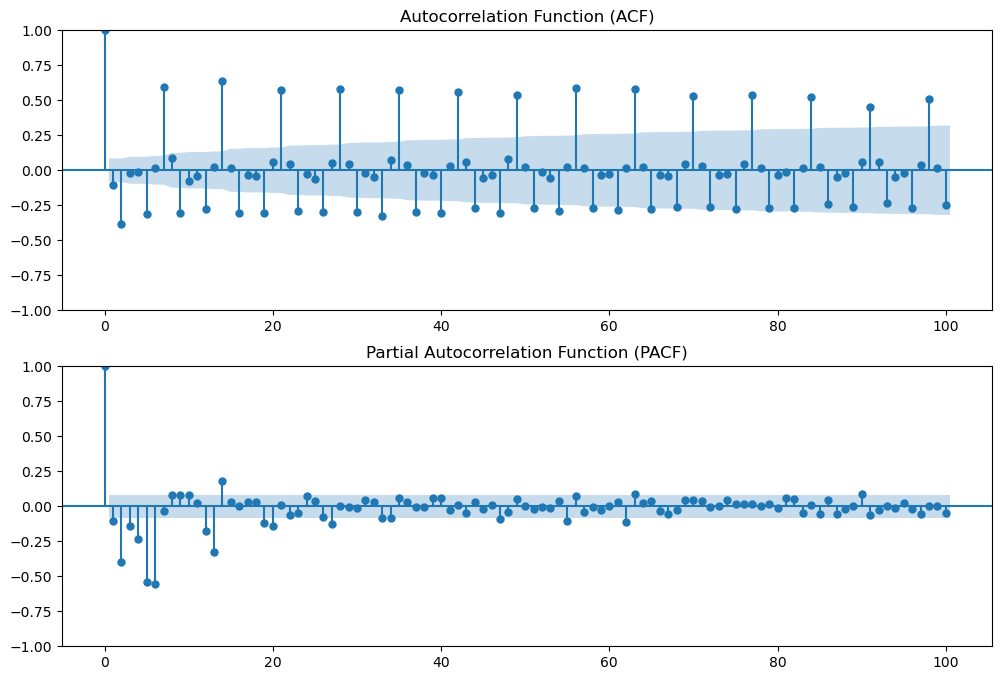

In [20]:
print("dataset ori")
adf_test(energy['y'], 'Original Series')
    
diff1 = energy['y'].diff().dropna()
print("1st differenced")
adf_test(diff1, 'First Differenced Series')
    
diff2 = diff1.diff().dropna()
print("2nd differenced")
adf_test(diff2, 'Second Differenced Series')
    
print("acf pcf plot")
stationary_series = diff1 if adfuller(diff1)[1] < 0.05 else diff2
analyze_acf_pacf(stationary_series)

In [450]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = list(train_arima)
predictions = []

for t in range(len(test_arima)):
    model = ARIMA(history,
                    order=(7, 0, 8))
    
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)

    obs = test_arima.iloc[t]
    history.append(obs)

    print(f"Step {t+1}/{len(test_arima)} - Actual: {obs:.2f}, Predicted: {yhat:.2f}")


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 1/110 - Actual: 158.99, Predicted: 139.12


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 2/110 - Actual: 60.84, Predicted: 9.51


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 3/110 - Actual: 0.00, Predicted: 0.78


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 4/110 - Actual: 149.21, Predicted: 152.90


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 5/110 - Actual: 167.15, Predicted: 183.31


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 6/110 - Actual: 169.67, Predicted: 154.69


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 7/110 - Actual: 142.67, Predicted: 187.02


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 8/110 - Actual: 136.70, Predicted: 143.37


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 9/110 - Actual: 0.00, Predicted: 21.63


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 10/110 - Actual: 0.00, Predicted: -5.57


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 11/110 - Actual: 153.21, Predicted: 151.16


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 12/110 - Actual: 149.11, Predicted: 176.60


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 13/110 - Actual: 157.12, Predicted: 149.90


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 14/110 - Actual: 168.18, Predicted: 177.23


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 15/110 - Actual: 171.91, Predicted: 145.98


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 16/110 - Actual: 0.00, Predicted: 18.28


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 17/110 - Actual: 0.00, Predicted: -8.01


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 18/110 - Actual: 223.72, Predicted: 155.79


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 19/110 - Actual: 187.41, Predicted: 183.85


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 20/110 - Actual: 177.52, Predicted: 156.20


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 21/110 - Actual: 185.35, Predicted: 190.07


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 22/110 - Actual: 160.99, Predicted: 154.94


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 23/110 - Actual: 0.00, Predicted: 22.34


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 24/110 - Actual: 0.00, Predicted: -2.95


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 25/110 - Actual: 188.36, Predicted: 167.72


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 26/110 - Actual: 170.24, Predicted: 189.01


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 27/110 - Actual: 158.41, Predicted: 161.34


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 28/110 - Actual: 155.45, Predicted: 189.54


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 29/110 - Actual: 160.72, Predicted: 156.85


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 30/110 - Actual: 0.00, Predicted: 14.58


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 31/110 - Actual: 0.00, Predicted: -8.73


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 32/110 - Actual: 0.00, Predicted: 165.57


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 33/110 - Actual: 231.30, Predicted: 151.65


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 34/110 - Actual: 191.60, Predicted: 160.83


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 35/110 - Actual: 182.13, Predicted: 154.89


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 36/110 - Actual: 178.73, Predicted: 151.71


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 37/110 - Actual: 0.00, Predicted: 7.22


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 38/110 - Actual: 0.00, Predicted: 12.80


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 39/110 - Actual: 229.79, Predicted: 135.87


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 40/110 - Actual: 193.85, Predicted: 199.88


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 41/110 - Actual: 0.00, Predicted: 164.78


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 42/110 - Actual: 215.92, Predicted: 159.75


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 43/110 - Actual: 205.06, Predicted: 168.40


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 44/110 - Actual: 0.00, Predicted: 0.42


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 45/110 - Actual: 0.00, Predicted: 12.74


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 46/110 - Actual: 235.02, Predicted: 137.36


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 47/110 - Actual: 191.97, Predicted: 212.06


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 48/110 - Actual: 175.47, Predicted: 138.14


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 49/110 - Actual: 151.66, Predicted: 195.68


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 50/110 - Actual: 136.27, Predicted: 164.43


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 51/110 - Actual: 0.00, Predicted: 14.89


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 52/110 - Actual: 0.00, Predicted: 4.96


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 53/110 - Actual: 177.70, Predicted: 147.07


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 54/110 - Actual: 161.78, Predicted: 204.72


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 55/110 - Actual: 154.76, Predicted: 128.96


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 56/110 - Actual: 158.09, Predicted: 193.25


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 57/110 - Actual: 149.79, Predicted: 145.46


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 58/110 - Actual: 0.00, Predicted: 19.21


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 59/110 - Actual: 0.00, Predicted: -9.22


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 60/110 - Actual: 173.34, Predicted: 159.21


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 61/110 - Actual: 154.57, Predicted: 191.43


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 62/110 - Actual: 151.78, Predicted: 134.78


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 63/110 - Actual: 141.62, Predicted: 188.12


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 64/110 - Actual: 145.81, Predicted: 143.06


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 65/110 - Actual: 0.00, Predicted: 15.89


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 66/110 - Actual: 0.00, Predicted: -15.09


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 67/110 - Actual: 194.39, Predicted: 165.08


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 68/110 - Actual: 173.49, Predicted: 180.81


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 69/110 - Actual: 162.70, Predicted: 143.17


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 70/110 - Actual: 151.72, Predicted: 178.28


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 71/110 - Actual: 147.49, Predicted: 151.84


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 72/110 - Actual: 10.33, Predicted: 13.38


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 73/110 - Actual: 0.00, Predicted: -5.79


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 74/110 - Actual: 193.35, Predicted: 168.74


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 75/110 - Actual: 164.44, Predicted: 184.59


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 76/110 - Actual: 168.66, Predicted: 146.26


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 77/110 - Actual: 184.16, Predicted: 174.76


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 78/110 - Actual: 170.03, Predicted: 159.73


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 79/110 - Actual: 0.00, Predicted: 10.71


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 80/110 - Actual: 0.00, Predicted: 1.61


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 81/110 - Actual: 185.07, Predicted: 168.30


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 82/110 - Actual: 136.85, Predicted: 187.22


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 83/110 - Actual: 108.86, Predicted: 145.01


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 84/110 - Actual: 0.00, Predicted: 169.08


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 85/110 - Actual: 96.26, Predicted: 122.87


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 86/110 - Actual: 0.00, Predicted: 5.21


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 87/110 - Actual: 0.00, Predicted: -16.75


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 88/110 - Actual: 98.97, Predicted: 160.92


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 89/110 - Actual: 0.00, Predicted: 151.32


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 90/110 - Actual: 110.07, Predicted: 98.32


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 91/110 - Actual: 104.71, Predicted: 142.52


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 92/110 - Actual: 106.26, Predicted: 113.84


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 93/110 - Actual: 0.00, Predicted: -10.58


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 94/110 - Actual: 0.00, Predicted: -26.52


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 95/110 - Actual: 154.81, Predicted: 144.38


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 96/110 - Actual: 149.59, Predicted: 145.45


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 97/110 - Actual: 141.93, Predicted: 126.73


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 98/110 - Actual: 141.29, Predicted: 154.68


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 99/110 - Actual: 144.81, Predicted: 130.72


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 100/110 - Actual: 0.00, Predicted: 2.06


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 101/110 - Actual: 0.00, Predicted: -11.41


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 102/110 - Actual: 178.83, Predicted: 154.50


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 103/110 - Actual: 151.07, Predicted: 157.68


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 104/110 - Actual: 139.41, Predicted: 144.63


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 105/110 - Actual: 135.43, Predicted: 157.30


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 106/110 - Actual: 141.03, Predicted: 141.81


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 107/110 - Actual: 0.00, Predicted: 5.40


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 108/110 - Actual: 0.00, Predicted: -0.73


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 109/110 - Actual: 0.00, Predicted: 155.27
Step 110/110 - Actual: 0.00, Predicted: 113.06


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
arima_model = pd.read_csv('./arima_new/arima_708')

In [22]:
#708
arima_score = evaluate(arima_model['actual'], arima_model['pred'])
print(f"MAE: {arima_score[0]:.4f}, MSE: {arima_score[1]:.4f}, R2S: {arima_score[2]:.4f}")

MAE: 27.5154, MSE: 2024.1518, R2S: 0.6855


In [17]:
#708
arima_score = evaluate(test_arima, predictions)
print(f"MAE: {arima_score[0]:.4f}, MSE: {arima_score[1]:.4f}, R2S: {arima_score[2]:.4f}")

MAE: 28.0612, MSE: 2080.6945, R2S: 0.6768


# **Peningkatan Akurasi**

## **Penambahan Fitur Berbasis Waktu**

In [16]:
#untuk xgboost, rf, svr
#energy_lag_final merupakan data yang sudah diberi lag dari proses sebelumnya
energy_lag_tb = energy_lag.copy()
df['Date'] = pd.to_datetime(df['Date'])
energy_lag_tb['day_of_week'] = energy_lag_tb['Date'].dt.dayofweek
energy_lag_tb['month'] = energy_lag_tb['Date'].dt.month
energy_lag_tb['is_weekend'] = energy_lag_tb['day_of_week'].isin([5, 6]).astype(int)

X_2d_tb = energy_lag_tb.drop(columns=['Date','y'])
y_2d_tb = energy_lag_tb['y'] 

In [35]:
energy_lag_tb

,Date,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,day_of_week,month,is_weekend
0,2018-07-08,0.000000,0.000000,182.726500,195.875167,200.101000,211.154500,226.172167,0.000000,6,7,1
1,2018-07-09,230.837167,0.000000,0.000000,182.726500,195.875167,200.101000,211.154500,226.172167,0,7,0
2,2018-07-10,206.843333,230.837167,0.000000,0.000000,182.726500,195.875167,200.101000,211.154500,1,7,0
3,2018-07-11,181.865667,206.843333,230.837167,0.000000,0.000000,182.726500,195.875167,200.101000,2,7,0
4,2018-07-12,176.875333,181.865667,206.843333,230.837167,0.000000,0.000000,182.726500,195.875167,3,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...
537,2019-12-27,141.029000,135.431333,139.406667,151.073667,178.834833,0.000000,0.000000,144.809000,4,12,0
538,2019-12-28,0.000000,141.029000,135.431333,139.406667,151.073667,178.834833,0.000000,0.000000,5,12,1
539,2019-12-29,0.000000,0.000000,141.029000,135.431333,139.406667,151.073667,178.834833,0.000000,6,12,1
540,2019-12-30,0.000000,0.000000,0.000000,141.029000,135.431333,139.406667,151.073667,178.834833,0,12,0


In [17]:
#untuk lstm
energy_tb = energy.copy()
df['Date'] = pd.to_datetime(df['Date'])
energy_tb['day_of_week'] = energy_tb['Date'].dt.dayofweek
energy_tb['month'] = energy_tb['Date'].dt.month
energy_tb['is_weekend'] = energy_tb['day_of_week'].isin([5, 6]).astype(int)
energy_tb = energy_tb.drop(columns=['Date'])

X_3d_tb, y_3d_tb = create_sequences(energy_tb.values, 7)

In [18]:
#data split
#untuk model xgboost, rf, svr
X_train_2d_tb, y_train_2d_tb, X_val_2d_tb, y_val_2d_tb, X_test_2d_tb, y_test_2d_tb = split_dataset(X_2d_tb, y_2d_tb)

#untuk model lstm
X_train_3d_tb, y_train_3d_tb, X_val_3d_tb, y_val_3d_tb, X_test_3d_tb, y_test_3d_tb = split_dataset(X_3d_tb, y_3d_tb)

In [19]:
#normalisasi data
#untuk model xgboost, rf, svr
X_train_2ds_tb, y_train_2ds_tb, X_val_2ds_tb, y_val_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y = norm_2d(X_train_2d_tb, y_train_2d_tb, X_val_2d_tb, y_val_2d_tb, X_test_2d_tb, y_test_2d_tb)

#untuk model lstm
X_train_3ds_tb, y_train_3ds_tb, X_val_3ds_tb, y_val_3ds_tb, X_test_3ds_tb, y_test_3ds_tb, scaler_y = norm_3d(X_train_3d_tb, y_train_3d_tb, X_val_3d_tb, y_val_3d_tb, X_test_3d_tb, y_test_3d_tb)

In [20]:
#pelatihan dan pengujian
#xgb
xgb_actual_tb, xgb_pred_tb, xgb_score_tb = apply_regressor(xgb.XGBRegressor(), X_train_2ds_tb, y_train_2ds_tb, X_val_2ds_tb, y_val_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {xgb_score_tb[0][0]:.4f}, MSE: {xgb_score_tb[0][1]:.4f}, R2S: {xgb_score_tb[0][2]:.4f}")
print(f"Validation Score - MAE: {xgb_score_tb[1][0]:.4f}, MSE: {xgb_score_tb[1][1]:.4f}, R2S: {xgb_score_tb[1][2]:.4f}")
print(f"Test Score - MAE: {xgb_score_tb[2][0]:.4f}, MSE: {xgb_score_tb[2][1]:.4f}, R2S: {xgb_score_tb[2][2]:.4f}")


Train Score - MAE: 0.3329, MSE: 1.4387, R2S: 0.9999
Validation Score - MAE: 28.6449, MSE: 2171.9046, R2S: 0.7528
Test Score - MAE: 26.1849, MSE: 2400.1544, R2S: 0.6291


In [21]:
#pelatihan dan pengujian
#rf
rf_actual_tb, rf_pred_tb, rf_score_tb = apply_regressor(RandomForestRegressor(random_state=12), X_train_2ds_tb, y_train_2ds_tb, X_val_2ds_tb, y_val_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {rf_score_tb[0][0]:.4f}, MSE: {rf_score_tb[0][1]:.4f}, R2S: {rf_score_tb[0][2]:.4f}")
print(f"Validation Score - MAE: {rf_score_tb[1][0]:.4f}, MSE: {rf_score_tb[1][1]:.4f}, R2S: {rf_score_tb[1][2]:.4f}")
print(f"Test Score - MAE: {rf_score_tb[2][0]:.4f}, MSE: {rf_score_tb[2][1]:.4f}, R2S: {rf_score_tb[2][2]:.4f}")

Train Score - MAE: 12.4777, MSE: 529.0733, R2S: 0.9454
Validation Score - MAE: 23.6539, MSE: 1995.4924, R2S: 0.7729
Test Score - MAE: 21.9673, MSE: 2124.7144, R2S: 0.6717


In [22]:
#pelatihan dan pengujian
#svr
svr_actual_tb, svr_pred_tb, svr_score_tb = apply_regressor(SVR(), X_train_2ds_tb, y_train_2ds_tb, X_val_2ds_tb, y_val_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {svr_score_tb[0][0]:.4f}, MSE: {svr_score_tb[0][1]:.4f}, R2S: {svr_score_tb[0][2]:.4f}")
print(f"Validation Score - MAE: {svr_score_tb[1][0]:.4f}, MSE: {svr_score_tb[1][1]:.4f}, R2S: {svr_score_tb[1][2]:.4f}")
print(f"Test Score - MAE: {svr_score_tb[2][0]:.4f}, MSE: {svr_score_tb[2][1]:.4f}, R2S: {svr_score_tb[2][2]:.4f}")

Train Score - MAE: 26.2997, MSE: 2382.4723, R2S: 0.7543
Validation Score - MAE: 29.7058, MSE: 2692.7245, R2S: 0.6935
Test Score - MAE: 26.4610, MSE: 2368.5706, R2S: 0.6340


In [66]:
model_lstm_tb = Sequential([
    InputLayer((7,4)),
    LSTM(64),
    Dense(1)
])

model_lstm_tb.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model_lstm_tb.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mse'])

model_lstm_tb.fit(X_train_3ds_tb, y_train_3ds_tb, validation_data=(X_val_3ds_tb, y_val_3ds_tb), epochs=100, batch_size=32)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1829 - mse: 0.1829 - val_loss: 0.1419 - val_mse: 0.1419
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1560 - mse: 0.1560 - val_loss: 0.1218 - val_mse: 0.1218
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1323 - mse: 0.1323 - val_loss: 0.1137 - val_mse: 0.1137
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1196 - mse: 0.1196 - val_loss: 0.1073 - val_mse: 0.1073
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1158 - mse: 0.1158 - val_loss: 0.1007 - val_mse: 0.1007
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1126 - mse: 0.1126 - val_loss: 0.0891 - val_mse: 0.0891
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0954 - mse: 0.0954 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0872 - mse: 0.0872 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0

In [23]:
#pelatihan dan pengujian
#lstm
model_lstm_tb = tf.keras.models.load_model('./lstm_model_new/lstm_tb.keras')
lstm_actual_tb, lstm_pred_tb, lstm_score_tb = forecast(model_lstm_tb, X_train_3ds_tb, y_train_3ds_tb, X_val_3ds_tb, y_val_3ds_tb, X_test_3ds_tb, y_test_3ds_tb, scaler_y)
print(f"Train Score - MAE: {lstm_score_tb[0][0]:.4f}, MSE: {lstm_score_tb[0][1]:.4f}, R2S: {lstm_score_tb[0][2]:.4f}")
print(f"Validation Score - MAE: {lstm_score_tb[1][0]:.4f}, MSE: {lstm_score_tb[1][1]:.4f}, R2S: {lstm_score_tb[1][2]:.4f}")
print(f"Test Score - MAE: {lstm_score_tb[2][0]:.4f}, MSE: {lstm_score_tb[2][1]:.4f}, R2S: {lstm_score_tb[2][2]:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train Score - MAE: 31.5047, MSE: 2680.0549, R2S: 0.7236
Validation Score - MAE: 29.2754, MSE: 2327.2361, R2S: 0.7351
Test Score - MAE: 26.3539, MSE: 2032.4140, R2S: 0.6859


In [645]:
#sarima
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = list(train_arima)
predictions = []

for t in range(len(test_arima)):
    model = SARIMAX(history,
                    order=(7, 0, 8),
                    seasonal_order=(0, 0, 0, 7),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    trend='c')  # intercept
    
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)

    obs = test_arima.iloc[t]
    history.append(obs)

    print(f"Step {t+1}/{len(test_arima)} - Actual: {obs:.2f}, Predicted: {yhat:.2f}")


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 1/110 - Actual: 158.99, Predicted: 139.31


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 2/110 - Actual: 60.84, Predicted: 22.23


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 3/110 - Actual: 0.00, Predicted: 8.46


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 4/110 - Actual: 149.21, Predicted: 158.78


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 5/110 - Actual: 167.15, Predicted: 176.26


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 6/110 - Actual: 169.67, Predicted: 140.53


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 7/110 - Actual: 142.67, Predicted: 178.62


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 8/110 - Actual: 136.70, Predicted: 145.18


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 9/110 - Actual: 0.00, Predicted: 27.57


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 10/110 - Actual: 0.00, Predicted: -1.00


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 11/110 - Actual: 153.21, Predicted: 154.09


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 12/110 - Actual: 149.11, Predicted: 169.28


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 13/110 - Actual: 157.12, Predicted: 144.27


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 14/110 - Actual: 168.18, Predicted: 167.99


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 15/110 - Actual: 171.91, Predicted: 145.82


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 16/110 - Actual: 0.00, Predicted: 28.85


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 17/110 - Actual: 0.00, Predicted: -1.19


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 18/110 - Actual: 223.72, Predicted: 156.13


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 19/110 - Actual: 187.41, Predicted: 181.64


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 20/110 - Actual: 177.52, Predicted: 150.14


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 21/110 - Actual: 185.35, Predicted: 178.49


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 22/110 - Actual: 160.99, Predicted: 156.53


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 23/110 - Actual: 0.00, Predicted: 34.81


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 24/110 - Actual: 0.00, Predicted: 8.40


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 25/110 - Actual: 188.36, Predicted: 169.26


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 26/110 - Actual: 170.24, Predicted: 183.59


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 27/110 - Actual: 158.41, Predicted: 149.66


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 28/110 - Actual: 155.45, Predicted: 175.73


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 29/110 - Actual: 160.72, Predicted: 146.35


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 30/110 - Actual: 0.00, Predicted: 27.17


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 31/110 - Actual: 0.00, Predicted: 2.49


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 32/110 - Actual: 0.00, Predicted: 168.18


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 33/110 - Actual: 231.30, Predicted: 147.14


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 34/110 - Actual: 191.60, Predicted: 154.91


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 35/110 - Actual: 182.13, Predicted: 162.62


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 36/110 - Actual: 178.73, Predicted: 161.75


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 37/110 - Actual: 0.00, Predicted: 5.77


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 38/110 - Actual: 0.00, Predicted: 7.32


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 39/110 - Actual: 229.79, Predicted: 144.82


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 40/110 - Actual: 193.85, Predicted: 199.64


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 41/110 - Actual: 0.00, Predicted: 166.68


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 42/110 - Actual: 215.92, Predicted: 150.75


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 43/110 - Actual: 205.06, Predicted: 161.64


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 44/110 - Actual: 0.00, Predicted: 9.42


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 45/110 - Actual: 0.00, Predicted: 17.42


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 46/110 - Actual: 235.02, Predicted: 139.61


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 47/110 - Actual: 191.97, Predicted: 204.56


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 48/110 - Actual: 175.47, Predicted: 143.20


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 49/110 - Actual: 151.66, Predicted: 192.34


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 50/110 - Actual: 136.27, Predicted: 161.26


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 51/110 - Actual: 0.00, Predicted: 19.37


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 52/110 - Actual: 0.00, Predicted: 11.06


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 53/110 - Actual: 177.70, Predicted: 157.39


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 54/110 - Actual: 161.78, Predicted: 192.17


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 55/110 - Actual: 154.76, Predicted: 133.65


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 56/110 - Actual: 158.09, Predicted: 177.43


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 57/110 - Actual: 149.79, Predicted: 147.93


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 58/110 - Actual: 0.00, Predicted: 18.10


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 59/110 - Actual: 0.00, Predicted: 3.52


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 60/110 - Actual: 173.34, Predicted: 158.47


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 61/110 - Actual: 154.57, Predicted: 184.92


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 62/110 - Actual: 151.78, Predicted: 131.66


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 63/110 - Actual: 141.62, Predicted: 175.32


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 64/110 - Actual: 145.81, Predicted: 142.73


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 65/110 - Actual: 0.00, Predicted: 15.08


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 66/110 - Actual: 0.00, Predicted: 1.69


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 67/110 - Actual: 194.39, Predicted: 162.92


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 68/110 - Actual: 173.49, Predicted: 182.27


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 69/110 - Actual: 162.70, Predicted: 136.60


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 70/110 - Actual: 151.72, Predicted: 172.53


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 71/110 - Actual: 147.49, Predicted: 145.18


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 72/110 - Actual: 10.33, Predicted: 19.70


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 73/110 - Actual: 0.00, Predicted: 3.19


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 74/110 - Actual: 193.35, Predicted: 167.95


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 75/110 - Actual: 164.44, Predicted: 184.31


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 76/110 - Actual: 168.66, Predicted: 137.26


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 77/110 - Actual: 184.16, Predicted: 173.02


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 78/110 - Actual: 170.03, Predicted: 149.71


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 79/110 - Actual: 0.00, Predicted: 24.51


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 80/110 - Actual: 0.00, Predicted: 5.61


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 81/110 - Actual: 185.07, Predicted: 173.90


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 82/110 - Actual: 136.85, Predicted: 184.83


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 83/110 - Actual: 108.86, Predicted: 138.56


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 84/110 - Actual: 0.00, Predicted: 165.40


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 85/110 - Actual: 96.26, Predicted: 114.31


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 86/110 - Actual: 0.00, Predicted: -2.89


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 87/110 - Actual: 0.00, Predicted: -14.73


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 88/110 - Actual: 98.97, Predicted: 162.27


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 89/110 - Actual: 0.00, Predicted: 145.74


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 90/110 - Actual: 110.07, Predicted: 88.48


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 91/110 - Actual: 104.71, Predicted: 122.18


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 92/110 - Actual: 106.26, Predicted: 111.06


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 93/110 - Actual: 0.00, Predicted: -2.80


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 94/110 - Actual: 0.00, Predicted: -26.85


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 95/110 - Actual: 154.81, Predicted: 147.01


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 96/110 - Actual: 149.59, Predicted: 132.28


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 97/110 - Actual: 141.93, Predicted: 113.53


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 98/110 - Actual: 141.29, Predicted: 141.62


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 99/110 - Actual: 144.81, Predicted: 137.34


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 100/110 - Actual: 0.00, Predicted: 16.14


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 101/110 - Actual: 0.00, Predicted: -3.25


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 102/110 - Actual: 178.83, Predicted: 161.10


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 103/110 - Actual: 151.07, Predicted: 153.79


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 104/110 - Actual: 139.41, Predicted: 131.91


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 105/110 - Actual: 135.43, Predicted: 145.94


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 106/110 - Actual: 141.03, Predicted: 141.31


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 107/110 - Actual: 0.00, Predicted: 14.87


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 108/110 - Actual: 0.00, Predicted: 3.94


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 109/110 - Actual: 0.00, Predicted: 164.07
Step 110/110 - Actual: 0.00, Predicted: 123.54


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
sarima_model = pd.read_csv('./arima_new/sarimax_708-000-7')
sarima_score = evaluate(sarima_model['actual'], sarima_model['pred'])
print(f"MAE: {sarima_score[0]:.4f}, MSE: {sarima_score[1]:.4f}, R2S: {sarima_score[2]:.4f}")

MAE: 27.0774, MSE: 2011.5045, R2S: 0.6875


## **Hyperparameter Tuning**

### **XGB**

In [ ]:
xgb_params = {
    'learning_rate': [0.3, 0.1, 0.05],
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'min_child_weight': [1, 3, 10] 
}

xgb_grid = GridSearchCV(xgb.XGBRegressor(), param_grid=xgb_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_absolute_error', verbose=3)
xgb_grid.fit(X_train_2ds_tb, y_train_2ds_tb)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
[CV 1/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6;, score=-0.119 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6;, score=-0.174 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6;, score=-0.246 total time=   0.0s
[CV 4/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6;, score=-0.250 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6;, score=-0.269 total time=   0.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, subsample=

In [49]:
xgb_ht = xgb.XGBRegressor(
    colsample_bytree=1.0,
    gamma=0.1,
    learning_rate=0.3,
    max_depth=9,
    min_child_weight=3,
    n_estimators=500,
    subsample=1.0
)

xgb_actual_ht, xgb_pred_ht, xgb_score_ht = apply_regressor(xgb_ht, X_train_2ds_tb, y_train_2ds_tb, X_val_2ds_tb, y_val_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {xgb_score_ht[0][0]:.4f}, MSE: {xgb_score_ht[0][1]:.4f}, R2S: {xgb_score_ht[0][2]:.4f}")
print(f"Validation Score - MAE: {xgb_score_ht[1][0]:.4f}, MSE: {xgb_score_ht[1][1]:.4f}, R2S: {xgb_score_ht[1][2]:.4f}")
print(f"Test Score - MAE: {xgb_score_ht[2][0]:.4f}, MSE: {xgb_score_ht[2][1]:.4f}, R2S: {xgb_score_ht[2][2]:.4f}")

Train Score - MAE: 21.3764, MSE: 1127.7807, R2S: 0.8837
Validation Score - MAE: 26.4286, MSE: 2096.0712, R2S: 0.7614
Test Score - MAE: 24.7359, MSE: 2199.1459, R2S: 0.6602


### **RF**

In [861]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestRegressor(), param_grid=rf_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', verbose=3)
rf_grid.fit(X_train_2ds_tb, y_train_2ds_tb)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.020 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.061 total time=   0.0s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.137 total time=   0.0s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.083 total time=   0.1s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=-0.112 total time=   0.0s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.019 total time=   0.0s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=-0.060 total time=   0.1s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, sc

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 7],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=3)

In [86]:
rf_ht = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=12
)
rf_actual_ht, rf_pred_ht, rf_score_ht = apply_regressor(rf_ht, X_train_2ds_tb, y_train_2ds_tb, X_val_2ds_tb, y_val_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {rf_score_ht[0][0]:.4f}, MSE: {rf_score_ht[0][1]:.4f}, R2S: {rf_score_ht[0][2]:.4f}")
print(f"Validation Score - MAE: {rf_score_ht[1][0]:.4f}, MSE: {rf_score_ht[1][1]:.4f}, R2S: {rf_score_ht[1][2]:.4f}")
print(f"Test Score - MAE: {rf_score_ht[2][0]:.4f}, MSE: {rf_score_ht[2][1]:.4f}, R2S: {rf_score_ht[2][2]:.4f}")

Train Score - MAE: 21.8835, MSE: 1619.5859, R2S: 0.8330
Validation Score - MAE: 24.3629, MSE: 2125.6690, R2S: 0.7581
Test Score - MAE: 20.8772, MSE: 1986.0707, R2S: 0.6931


### **SVR**

In [264]:
svr_params = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.001, 0.01, 0.1, 1],
    'gamma': ['scale', 0.01, 0.1, 1]
}
svr_grid = GridSearchCV(SVR(), param_grid=svr_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', verbose=3)
svr_grid.fit(X_train_2ds_tb, y_train_2ds_tb)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=0.1, epsilon=0.001, gamma=scale;, score=-0.025 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.001, gamma=scale;, score=-0.066 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.001, gamma=scale;, score=-0.111 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.001, gamma=scale;, score=-0.034 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.001, gamma=scale;, score=-0.104 total time=   0.0s
[CV 1/5] END .C=0.1, epsilon=0.001, gamma=0.01;, score=-0.134 total time=   0.0s
[CV 2/5] END .C=0.1, epsilon=0.001, gamma=0.01;, score=-0.144 total time=   0.0s
[CV 3/5] END .C=0.1, epsilon=0.001, gamma=0.01;, score=-0.189 total time=   0.0s
[CV 4/5] END .C=0.1, epsilon=0.001, gamma=0.01;, score=-0.074 total time=   0.0s
[CV 5/5] END .C=0.1, epsilon=0.001, gamma=0.01;, score=-0.125 total time=   0.0s
[CV 1/5] END ..C=0.1, epsilon=0.001, gamma=0.1;, score=-0.032 total time=   0.0s
[CV 2/5] END ..C=0.1, epsilon=0.001, gamma=0.1;

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'epsilon': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error', verbose=3)

In [76]:
svr_ht = SVR(
    C=0.1,
    epsilon=0.001,
    gamma='scale'
)
svr_actual_ht, svr_pred_ht, svr_score_ht = apply_regressor(svr_ht,  X_train_2ds_tb, y_train_2ds_tb, X_val_2ds_tb, y_val_2ds_tb, X_test_2ds_tb, y_test_2ds_tb, scaler_y)
print(f"Train Score - MAE: {svr_score_ht[0][0]:.4f}, MSE: {svr_score_ht[0][1]:.4f}, R2S: {svr_score_ht[0][2]:.4f}")
print(f"Validation Score - MAE: {svr_score_ht[1][0]:.4f}, MSE: {svr_score_ht[1][1]:.4f}, R2S: {svr_score_ht[1][2]:.4f}")
print(f"Test Score - MAE: {svr_score_ht[2][0]:.4f}, MSE: {svr_score_ht[2][1]:.4f}, R2S: {svr_score_ht[2][2]:.4f}")

Train Score - MAE: 26.6940, MSE: 2902.6529, R2S: 0.7007
Validation Score - MAE: 31.6593, MSE: 2758.1337, R2S: 0.6861
Test Score - MAE: 28.7000, MSE: 2363.7745, R2S: 0.6347


### **LSTM**

In [ ]:
def build_lstm(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(X_train_3ds_tb.shape[1], X_train_3ds_tb.shape[2])))
    model.add(LSTM(units, activation='relu'))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(1, activation='linear')) 
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
    return model

model = KerasRegressor(model=build_lstm, verbose=1)

param_grid = {
    'model__units': [64, 128],                 
    'model__dropout_rate': [0.2, 0.3],        
    'batch_size': [10, 16, 32],                   
    'epochs': [20, 50, 100],                       
    'model__learning_rate': [0.001, 0.005] 
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_squared_error',
    verbose=2
)

grid_search.fit(X_train_3ds_tb, y_train_3ds_tb)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3939 - mse: 0.3939
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2454 - mse: 0.2454 
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1516 - mse: 0.1516 
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1362 - mse: 0.1362 
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1237 - mse: 0.1237 
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1309 - mse: 0.1309 
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1475 - mse: 0.1475 
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1376 - mse: 0.1376 
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1287 - mse: 0.1287 
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1113 - mse: 0.1113 
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1140 - mse: 0.1140 
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1259 - mse: 0.1259 


In [490]:
model_lstm_ht = Sequential([
    InputLayer((7, 4)),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dense(1, activation='linear')
])

model_lstm_ht.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_1 (Dropout)                  │ (None, 7, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [492]:
model_lstm_ht.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.005), metrics=['mse'])

model_lstm_ht.fit(X_train_3ds_tb, y_train_3ds_tb, validation_data=(X_val_3ds_tb, y_val_3ds_tb), epochs=20, batch_size=10)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1671 - mse: 0.1671 - val_loss: 0.1012 - val_mse: 0.1012
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1000 - mse: 0.1000 - val_loss: 0.0617 - val_mse: 0.0617
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0992 - mse: 0.0992 - val_loss: 0.0854 - val_mse: 0.0854
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0932 - mse: 0.0932 - val_loss: 0.0660 - val_mse: 0.0660
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0831 - mse: 0.0831 - val_loss: 0.0467 - val_mse: 0.0467
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0761 - mse: 0.0761 - val_loss: 0.0447 - val_mse: 0.0447
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0746 - mse: 0.0746 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0731 - mse: 0.0731 - val_loss: 0.0537 - val_mse: 0.0537
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0719 - mse:

In [77]:
model_lstm_ht=tf.keras.models.load_model('./lstm_model_new/lstm_ht.keras')
lstm_actual_ht, lstm_pred_ht, lstm_score_ht = forecast(model_lstm_ht, X_train_3ds_tb, y_train_3ds_tb, X_val_3ds_tb, y_val_3ds_tb, X_test_3ds_tb, y_test_3ds_tb, scaler_y)
print(f"Train Score - MAE: {lstm_score_ht[0][0]:.4f}, MSE: {lstm_score_ht[0][1]:.4f}, R2S: {lstm_score_ht[0][2]:.4f}")
print(f"Validation Score - MAE: {lstm_score_ht[1][0]:.4f}, MSE: {lstm_score_ht[1][1]:.4f}, R2S: {lstm_score_ht[1][2]:.4f}")
print(f"Test Score - MAE: {lstm_score_ht[2][0]:.4f}, MSE: {lstm_score_ht[2][1]:.4f}, R2S: {lstm_score_ht[2][2]:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train Score - MAE: 37.4271, MSE: 2889.2910, R2S: 0.7021
Validation Score - MAE: 30.6080, MSE: 2416.8167, R2S: 0.7249
Test Score - MAE: 26.3465, MSE: 1904.5207, R2S: 0.7057


### **ARIMA**

In [346]:
from pmdarima import auto_arima

In [609]:
arima_ht = auto_arima(train_arima, 
                      start_p=0, 
                      d=0, 
                      start_q=0, 
                      max_p=10, 
                      max_q=10, 
                      start_P=0, 
                      D=0, 
                      start_Q=0, 
                      max_P=10, 
                      max_Q=10, 
                      m=7, 
                      seasonal=True, 
                      trace=True, 
                      supress_warning=True, 
                      stepwise=False, 
                      n_fits=50)

 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5270.475, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=5135.776, Time=0.15 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=5040.834, Time=0.30 sec
 ARIMA(0,0,0)(0,0,3)[7] intercept   : AIC=5020.234, Time=0.36 sec
 ARIMA(0,0,0)(0,0,4)[7] intercept   : AIC=5008.895, Time=0.87 sec
 ARIMA(0,0,0)(0,0,5)[7] intercept   : AIC=4964.851, Time=1.80 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=5001.696, Time=0.19 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=4891.770, Time=0.87 sec
 ARIMA(0,0,0)(1,0,3)[7] intercept   : AIC=4947.163, Time=1.73 sec
 ARIMA(0,0,0)(1,0,4)[7] intercept   : AIC=5002.855, Time=2.01 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=4930.919, Time=0.61 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,0,0)(2,0,3)[7] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,0,0)(3,0,0)[7] interc

In [464]:
arima_ht.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  439
Model:             SARIMAX(0, 0, 1)x(6, 0, [], 7)   Log Likelihood               -2427.233
Date:                            Tue, 20 May 2025   AIC                           4872.466
Time:                                    12:13:59   BIC                           4909.227
Sample:                                         0   HQIC                          4886.970
                                            - 439                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.0154      8.768      1.598      0.110      -3.170      31.201
ma.L1          0.2434      0.039      6.284      0.000       0.167       0.319
ar.S.L7        0.2202      0.037      6.019      0.000       0.148       0.292
ar.S.L14       0.2658      0.035      7.648      0.000       0.198       0.334
ar.S.L21       0.0454      0.038      1.189      0.234      -0.029       0.120
ar.S.L28       0.0899      0.037      2.437      0.015       0.018       0.162
ar.S.L35       0.1750      0.040      4.371      0.000       0.097       0.253
ar.S.L42       0.0890      0.041      2.178      0.029       0.009       0.169
sigma2      3612.3877    236.068     15.302      0.000    3149.704    4075.072
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               165.49
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.92
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [611]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = list(train_arima)
predictions = []

for t in range(len(test_arima)):
    model = SARIMAX(history,
                    order=(1, 0, 0),
                    seasonal_order=(1, 0, 1, 7),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    trend='c')  # intercept
    
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)

    obs = test_arima.iloc[t]
    history.append(obs)

    print(f"Step {t+1}/{len(test_arima)} - Actual: {obs:.2f}, Predicted: {yhat:.2f}")


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 1/110 - Actual: 158.99, Predicted: 155.66
Step 2/110 - Actual: 60.84, Predicted: 2.28
Step 3/110 - Actual: 0.00, Predicted: 21.24


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 4/110 - Actual: 149.21, Predicted: 162.55
Step 5/110 - Actual: 167.15, Predicted: 172.36


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 6/110 - Actual: 169.67, Predicted: 174.58
Step 7/110 - Actual: 142.67, Predicted: 173.43


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 8/110 - Actual: 136.70, Predicted: 154.42


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 9/110 - Actual: 0.00, Predicted: -1.84


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 10/110 - Actual: 0.00, Predicted: 3.00


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 11/110 - Actual: 153.21, Predicted: 162.01


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 12/110 - Actual: 149.11, Predicted: 172.81


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 13/110 - Actual: 157.12, Predicted: 168.83


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 14/110 - Actual: 168.18, Predicted: 168.52


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 15/110 - Actual: 171.91, Predicted: 161.03


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 16/110 - Actual: 0.00, Predicted: 8.68


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 17/110 - Actual: 0.00, Predicted: 2.81


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 18/110 - Actual: 223.72, Predicted: 161.76
Step 19/110 - Actual: 187.41, Predicted: 193.31


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 20/110 - Actual: 177.52, Predicted: 180.00


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 21/110 - Actual: 185.35, Predicted: 175.59


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 22/110 - Actual: 160.99, Predicted: 169.47


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 23/110 - Actual: 0.00, Predicted: 6.38


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 24/110 - Actual: 0.00, Predicted: 2.61


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 25/110 - Actual: 188.36, Predicted: 163.29


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 26/110 - Actual: 170.24, Predicted: 183.24


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 27/110 - Actual: 158.41, Predicted: 175.17


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 28/110 - Actual: 155.45, Predicted: 169.73


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 29/110 - Actual: 160.72, Predicted: 158.48


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 30/110 - Actual: 0.00, Predicted: 2.53


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 31/110 - Actual: 0.00, Predicted: 0.82


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 32/110 - Actual: 0.00, Predicted: 163.49


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 33/110 - Actual: 231.30, Predicted: 135.30


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 34/110 - Actual: 191.60, Predicted: 191.41


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 35/110 - Actual: 182.13, Predicted: 179.55


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 36/110 - Actual: 178.73, Predicted: 164.96


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 37/110 - Actual: 0.00, Predicted: 10.98


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 38/110 - Actual: 0.00, Predicted: 2.79


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 39/110 - Actual: 229.79, Predicted: 160.63


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 40/110 - Actual: 193.85, Predicted: 197.34


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 41/110 - Actual: 0.00, Predicted: 181.61


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 42/110 - Actual: 215.92, Predicted: 125.22
Step 43/110 - Actual: 205.06, Predicted: 174.03


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 44/110 - Actual: 0.00, Predicted: 16.02


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 45/110 - Actual: 0.00, Predicted: 2.22


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 46/110 - Actual: 235.02, Predicted: 158.02


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 47/110 - Actual: 191.97, Predicted: 196.23


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 48/110 - Actual: 175.47, Predicted: 178.11
Step 49/110 - Actual: 151.66, Predicted: 175.79


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 50/110 - Actual: 136.27, Predicted: 159.21


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 51/110 - Actual: 0.00, Predicted: -6.48


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 52/110 - Actual: 0.00, Predicted: 2.24


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 53/110 - Actual: 177.70, Predicted: 162.95


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 54/110 - Actual: 161.78, Predicted: 180.59


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 55/110 - Actual: 154.76, Predicted: 169.72


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 56/110 - Actual: 158.09, Predicted: 172.43


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 57/110 - Actual: 149.79, Predicted: 159.12


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 58/110 - Actual: 0.00, Predicted: 1.35


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 59/110 - Actual: 0.00, Predicted: 2.11


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 60/110 - Actual: 173.34, Predicted: 163.09


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 61/110 - Actual: 154.57, Predicted: 178.81


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 62/110 - Actual: 151.78, Predicted: 166.64


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 63/110 - Actual: 141.62, Predicted: 168.58


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 64/110 - Actual: 145.81, Predicted: 154.07


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 65/110 - Actual: 0.00, Predicted: -0.17
Step 66/110 - Actual: 0.00, Predicted: 1.92
Step 67/110 - Actual: 194.39, Predicted: 162.37


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 68/110 - Actual: 173.49, Predicted: 183.61


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 69/110 - Actual: 162.70, Predicted: 171.90


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 70/110 - Actual: 151.72, Predicted: 170.53


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 71/110 - Actual: 147.49, Predicted: 157.10


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 72/110 - Actual: 10.33, Predicted: 0.41


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 73/110 - Actual: 0.00, Predicted: 7.91


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 74/110 - Actual: 193.35, Predicted: 162.61


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 75/110 - Actual: 164.44, Predicted: 183.29


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 76/110 - Actual: 168.66, Predicted: 166.66


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 77/110 - Actual: 184.16, Predicted: 171.65


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 78/110 - Actual: 170.03, Predicted: 165.48


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 79/110 - Actual: 0.00, Predicted: 6.22


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 80/110 - Actual: 0.00, Predicted: 2.75


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 81/110 - Actual: 185.07, Predicted: 162.93


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 82/110 - Actual: 136.85, Predicted: 180.94


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 83/110 - Actual: 108.86, Predicted: 159.88


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 84/110 - Actual: 0.00, Predicted: 156.49


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 85/110 - Actual: 96.26, Predicted: 110.80


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 86/110 - Actual: 0.00, Predicted: -14.35


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 87/110 - Actual: 0.00, Predicted: 1.38


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 88/110 - Actual: 98.97, Predicted: 161.37


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 89/110 - Actual: 0.00, Predicted: 156.68


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 90/110 - Actual: 110.07, Predicted: 119.02
Step 91/110 - Actual: 104.71, Predicted: 150.03


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 92/110 - Actual: 106.26, Predicted: 139.07


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 93/110 - Actual: 0.00, Predicted: -9.96


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 94/110 - Actual: 0.00, Predicted: 1.18


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 95/110 - Actual: 154.81, Predicted: 157.37


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 96/110 - Actual: 149.59, Predicted: 165.85


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 97/110 - Actual: 141.93, Predicted: 159.92


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 98/110 - Actual: 141.29, Predicted: 155.84


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 99/110 - Actual: 144.81, Predicted: 148.37


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 100/110 - Actual: 0.00, Predicted: 0.50


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 101/110 - Actual: 0.00, Predicted: 1.05


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 102/110 - Actual: 178.83, Predicted: 156.79


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 103/110 - Actual: 151.07, Predicted: 172.11


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 104/110 - Actual: 139.41, Predicted: 159.82


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 105/110 - Actual: 135.43, Predicted: 156.25


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 106/110 - Actual: 141.03, Predicted: 146.39


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 107/110 - Actual: 0.00, Predicted: -0.70


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 108/110 - Actual: 0.00, Predicted: 0.87


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Step 109/110 - Actual: 0.00, Predicted: 156.49
Step 110/110 - Actual: 0.00, Predicted: 119.18


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [78]:
arima_ht = pd.read_csv('./arima_new/sarimax_100-101-7')
arima_score_ht = evaluate(arima_ht['actual'], arima_ht['pred'])
print(f"MAE: {arima_score_ht[0]:.4f}, MSE: {arima_score_ht[1]:.4f}, R2S: {arima_score_ht[2]:.4f}")

MAE: 23.6817, MSE: 1923.1133, R2S: 0.7012


# **Score**

In [79]:
score_baseline = pd.DataFrame({
    'regressor': ['XGB', 'Random Forest', 'SVR', 'LSTM', 'ARIMA'], 
    'MAE': [xgb_score[2][0], rf_score[2][0], svr_score[2][0], lstm_score[2][0], arima_score[0]],
    'MSE': [xgb_score[2][1], rf_score[2][1], svr_score[2][1], lstm_score[2][1], arima_score[1]],
    'R2S': [xgb_score[2][2], rf_score[2][2], svr_score[2][2], lstm_score[2][2], arima_score[2]]
})
score_baseline

,regressor,MAE,MSE,R2S
0,XGB,34.150930,2650.151896,0.590465
1,Random Forest,28.574680,2415.330788,0.626752
2,SVR,29.916852,2603.773813,0.597632
3,LSTM,28.804654,2208.810899,0.658666
4,ARIMA,27.515417,2024.151764,0.685542


In [84]:
score_ht.to_csv('./scores_final/score_ht.csv', index=False)

In [80]:
score_tb = pd.DataFrame({
    'regressor': ['XGB', 'Random Forest', 'SVR', 'LSTM', 'ARIMA'],
    'MAE': [xgb_score_tb[2][0], rf_score_tb[2][0], svr_score_tb[2][0], lstm_score_tb[2][0], sarima_score[0]],
    'MSE': [xgb_score_tb[2][1], rf_score_tb[2][1], svr_score_tb[2][1], lstm_score_tb[2][1], sarima_score[1]],
    'R2S': [xgb_score_tb[2][2], rf_score_tb[2][2], svr_score_tb[2][2], lstm_score_tb[2][2], sarima_score[2]]
})
score_tb

,regressor,MAE,MSE,R2S
0,XGB,26.184902,2400.154440,0.629097
1,Random Forest,21.967330,2124.714361,0.671662
2,SVR,26.460990,2368.570627,0.633978
3,LSTM,26.353929,2032.413982,0.685925
4,ARIMA,27.077380,2011.504533,0.687506


In [93]:
score_ht = pd.DataFrame({
    'regressor': ['XGB', 'Random Forest', 'SVR', 'LSTM', 'ARIMA'], 
    'MAE': [xgb_score_ht[2][0], rf_score_ht[2][0], svr_score_ht[2][0], lstm_score_ht[2][0], arima_score_ht[0]],
    'MSE': [xgb_score_ht[2][1], rf_score_ht[2][1], svr_score_ht[2][1], lstm_score_ht[2][1], arima_score_ht[1]],
    'R2S': [xgb_score_ht[2][2], rf_score_ht[2][2], svr_score_ht[2][2], lstm_score_ht[2][2], arima_score_ht[2]]
})
score_ht

,regressor,MAE,MSE,R2S
0,XGB,24.735942,2199.145863,0.660160
1,Random Forest,20.877240,1986.070723,0.693087
2,SVR,28.699981,2363.774476,0.634719
3,LSTM,26.346539,1904.520660,0.705689
4,ARIMA,23.681651,1923.113323,0.701238
